# Puzzle solving
## Matej Kopecky

In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from utils import Segmentation
segmenter = Segmentation()

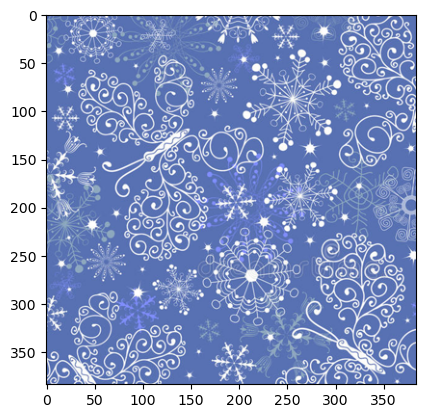

In [75]:
img = segmenter.load_input_image_("00_00", folder="train2_solutions", flag='solution')
plt.imshow(img)

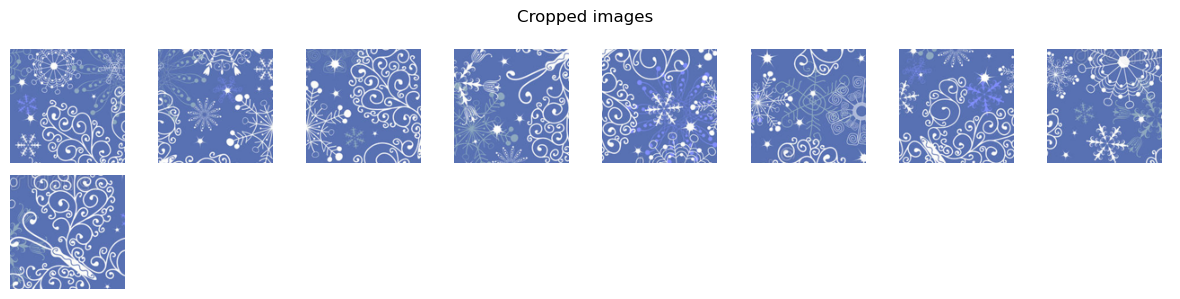

In [112]:
img = segmenter.load_input_image_("00_00", folder="train2_solutions", flag='solution')

def split_image(img, size=128):
    if img.shape[0] % size != 0 or img.shape[1] % size != 0:
        raise ValueError(f"Image size is wrong for piece size {size}x{size}.")
    
    piece_vert = img.shape[0]//size
    piece_hori = img.shape[1]//size

    pieces = []
    for i in range(piece_vert):
        for j in range(piece_hori):
            new_piece = img[i*size:(i+1)*size, j*size:(j+1)*size,:]
            pieces.append(new_piece)

    return pieces
    
pieces = split_image(img)
#pieces[0][:,-1] = [0,0,0]

Segmentation.plot_images(pieces)

In [71]:
pieces[0][-1,:].shape

(128, 3)

In [147]:
def get_edge_pixels(img):
    top = img[0,:]
    bottom = img[-1,:]
    left = img[:,0]
    right = img[:,-1]

    edges = np.array([top, right, bottom, left])

    return edges

edges = [get_edge_pixels(pieces[i]) for i in range(2)]

In [148]:
def find_two_best_edges(edges):
    piece_0 = edges[0]
    piece_1 = edges[1]
    last_mse = float('inf')
    indexes = (-1, -1)
    for i in range(piece_0.shape[0]):
        for j in range(piece_1.shape[0]):
           squared_diff = (piece_0[i] - piece_1[j]) ** 2
           mse = np.mean(squared_diff)
           print(f"{(i,j)}, mse: {mse:.2f}")
           if mse < last_mse:
               last_mse = mse
               indexes = (i,j)
    return indexes

indexes = find_two_best_edges(edges)
print(indexes)
               

(0, 0), mse: 78.31
(0, 1), mse: 84.77
(0, 2), mse: 83.63
(0, 3), mse: 87.24
(1, 0), mse: 84.99
(1, 1), mse: 85.52
(1, 2), mse: 83.73
(1, 3), mse: 69.56
(2, 0), mse: 77.15
(2, 1), mse: 87.02
(2, 2), mse: 88.71
(2, 3), mse: 76.94
(3, 0), mse: 74.65
(3, 1), mse: 64.89
(3, 2), mse: 61.43
(3, 3), mse: 68.20
(3, 2)


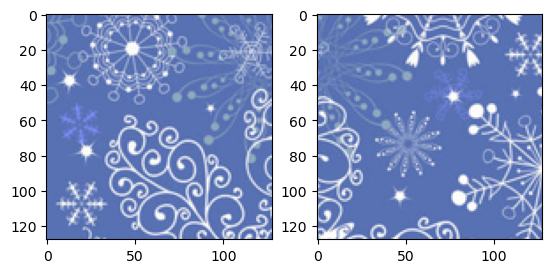

In [149]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(pieces[0])
axes[1].imshow(pieces[1])

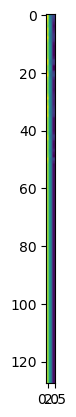

In [150]:
from skimage import io, color
lab = color.rgb2lab(edges[0][3])
plt.imshow(lab)

In [151]:
def calculate_lab_distance(edges):
    piece_0 = edges[0]
    piece_1 = edges[1]
    last_distance = float('inf')
    edge_indexes = (-1, -1)
    for i in range(piece_0.shape[0]):
        for j in range(piece_1.shape[0]):
           lab_0 = color.rgb2lab(piece_0[i])
           lab_1 = color.rgb2lab(piece_1[j])
           delta_e = np.linalg.norm(lab_0 - lab_1, axis=1)
           average_distance = np.mean(delta_e)
           print(f"{(i,j)}, mse: {average_distance:.2f}")
           if average_distance < last_distance:
               last_distance = average_distance
               edge_indexes = (i,j)
    return edge_indexes

edge_indexes = calculate_lab_distance(edges)
print(edge_indexes)

(0, 0), mse: 21.62
(0, 1), mse: 20.35
(0, 2), mse: 23.28
(0, 3), mse: 18.16
(1, 0), mse: 23.02
(1, 1), mse: 24.12
(1, 2), mse: 25.06
(1, 3), mse: 10.84
(2, 0), mse: 20.01
(2, 1), mse: 23.80
(2, 2), mse: 25.12
(2, 3), mse: 17.93
(3, 0), mse: 20.88
(3, 1), mse: 18.07
(3, 2), mse: 17.87
(3, 3), mse: 15.23
(1, 3)


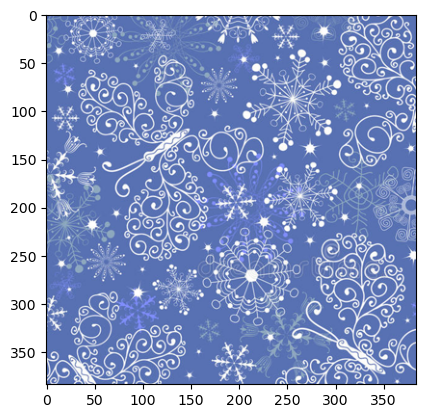

In [152]:
import imutils
angle = 0
rotated = imutils.rotate(img, angle)
plt.imshow(rotated)

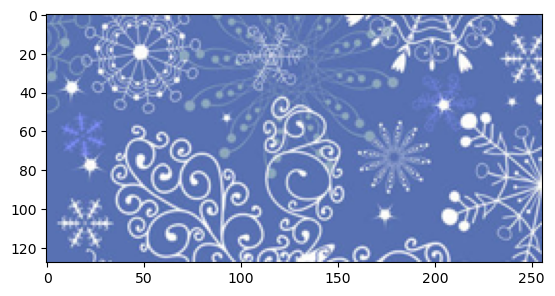

In [155]:
def put_together(pieces, edge_indexes):
    index1 = edge_indexes[0]
    index2 = edge_indexes[1]

    image1 = pieces[0]
    image2 = pieces[1]

    # Rotate the second image if necessary
    '''
    if index2 == 1:
        image2 = imutils.rotate(image2, angle=-90)
    elif index2 == 2:
        image2 = imutils.rotate(image2, angle=180)
    elif index2 == 3:
        image2 = imutils.rotate(image2, angle=90)
    '''
    # Combine the images based on the indexes
    if index1 == 0:
        combined = np.vstack((image2, image1))
    elif index1 == 1:
        combined = np.hstack((image1, image2))
    elif index1 == 2:
        combined = np.vstack((image1, image2))
    elif index1 == 3:
        combined = np.hstack((image2, image1))

    if index1 == 1 and index2 == 3:
        combined = np.hstack((image1, image2))
    elif index1 == 3 and index2 == 1:
        combined = np.hstack((image2, image1))


    return combined

combined = put_together(pieces, edge_indexes)
plt.imshow(combined)

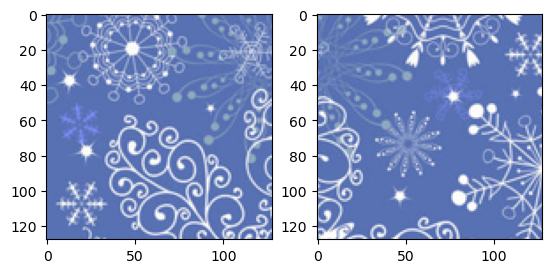

In [154]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(pieces[0])
axes[1].imshow(pieces[1])